In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
twt_ods = read_OD_fn('TWT')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [6]:
lista_twt = []

for date in tqdm_notebook(target_days):
    lista_twt.append(twt_ods[date].loc['total','total'])
    
del twt_ods
    
lista_ine = []

for date in tqdm_notebook(target_days):
    lista_ine.append(ine_ods[date].loc['total','total'])
    
del ine_ods

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [7]:
df_twt = pd.DataFrame (lista_twt, columns = ['Viajes'], index= target_days)
df_ine = pd.DataFrame (lista_ine, columns = ['Viajes'], index= target_days)

In [8]:
df_twt.head()

,Viajes
2020-04-01,2375
2020-04-02,2450
2020-04-03,2503
2020-04-04,554
2020-04-05,1319


# Visualización de datos

In [9]:
print(df_twt.index.min())
print(df_ine.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [10]:
print(len(df_twt['2020']))

81


In [11]:
print(len(df_ine['2020']))

81


In [12]:
df_twt.describe()

,Viajes
count,81.000000
mean,2943.000000
std,887.069149
min,0.000000
25%,2363.000000
50%,2904.000000
75%,3629.000000
max,4738.000000


In [13]:
df_ine.describe()

,Viajes
count,8.100000e+01
mean,3.438222e+06
std,1.174931e+06
min,1.535886e+06
25%,2.488436e+06
50%,3.396402e+06
75%,4.445190e+06
max,5.519725e+06


In [14]:
meses = df_twt.resample('M').mean()
meses

,Viajes
2020-04-30,2157.500000
2020-05-31,3128.193548
2020-06-30,3834.200000


In [15]:
meses = df_ine.resample('M').mean()
meses

,Viajes
2020-04-30,2.356878e+06
2020-05-31,3.590722e+06
2020-06-30,4.823862e+06


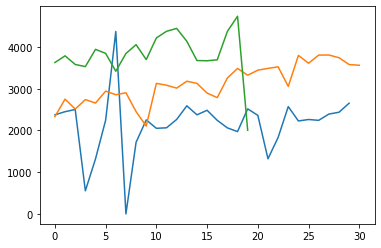

In [16]:
abril = df_twt['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_twt['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_twt['2020-06-01':'2020-06-20']
plt.plot(junio.values)

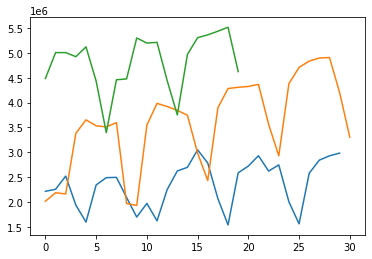

In [17]:
abril = df_ine['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df_ine['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df_ine['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [18]:
dataset_twt = df_twt.values
dataset_twt = dataset_twt.astype('float32')

dataset_ine = df_ine.values
dataset_ine = dataset_ine.astype('float32')

In [19]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

# Dividimos los datos en sets de entrenamiento y validacion

In [20]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train_twt = dataset_twt[:n_train_days, :]
test_twt = dataset_twt[n_train_days:, :]

train_ine = dataset_ine[:n_train_days, :]
test_ine = dataset_ine[n_train_days:, :]

print(len(train_twt), len(test_twt))

60 21


In [21]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset1, dataset2, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [22]:
# dividimos en entradas y salidas
look_back = 7
trainX, trainY = create_dataset(train_twt, train_ine, look_back)
testX, testY = create_dataset(test_twt, test_ine, look_back)

print(len(trainX), len(testY))

53 14


In [23]:
print(trainX)

[[[[0.16999608 0.50126636]]

  [[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]]


 [[[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]]


 [[[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]]


 [[[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]]


 [[[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]

  [[0.

In [24]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


In [25]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 2))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 2))

In [26]:
print(trainX)

[[[0.16999608 0.50126636]
  [0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]]

 [[0.18028718 0.5170958 ]
  [0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]]

 [[0.2470504  0.528282  ]
  [0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]]

 [[0.10007131 0.11692698]
  [0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]]

 [[0.01443306 0.27838752]
  [0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  [0.1389401  0.3623892 ]
  [0.03971621 0.4755171 ]
  [0.10891479 0.43309414]]

 [[0.20226192 0.47425076]
  [0.23910356 0.9229633 ]
  [0.24053836 0.        ]
  

In [27]:
print(trainY)

[0.24053836 0.1389401  0.03971621 0.10891479 0.02047423 0.17865783
 0.27293295 0.2914425  0.37988257 0.313093   0.13297123 0.
 0.26343662 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752
 0.00537395 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008
 0.16276813 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993
 0.51747626 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086
 0.5796803  0.5546241  0.3633111  0.22455525 0.59261984 0.689921
 0.6962447  0.7003162  0.71110225 0.50901634 0.34968656 0.7144731
 0.7966052  0.82881963 0.8441757  0.8469062  0.6693162 ]


# Creamos la red neuronal

In [28]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,2), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,2), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,2)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [29]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,541
Trainable params: 76,541
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0103 - val_loss: 0.0161
Epoch 124/200
53/53 - 0s - loss: 0.0104 - val_loss: 0.0135
Epoch 125/200
53/53 - 0s - loss: 0.0113 - val_loss: 0.0081
Epoch 126/200
53/53 - 0s - loss: 0.0100 - val_loss: 0.0042
Epoch 127/200
53/53 - 0s - loss: 0.0096 - val_loss: 0.0055
Epoch 128/200
53/53 - 0s - loss: 0.0097 - val_loss: 0.0069
Epoch 129/200
53/53 - 0s - loss: 0.0091 - val_loss: 0.0085
Epoch 130/200
53/53 - 0s - loss: 0.0098 - val_loss: 0.0074
Epoch 131/200
53/53 - 0s - loss: 0.0110 - val_loss: 0.0110
Epoch 132/200
53/53 - 0s - loss: 0.0088 - val_loss: 0.0046
Epoch 133/200
53/53 - 0s - loss: 0.0088 - val_loss: 0.0103
Epoch 134/200
53/53 - 0s - loss: 0.0088 - val_loss: 0.0065
Epoch 135/200
53/53 - 0s - loss: 0.0093 - val_loss: 0.0052
Epoch 136/200
53/53 - 0s - loss: 0.0123 - val_loss: 0.0085
Epoch 137/200
53/53 - 0s - loss: 0.0087 - val_loss: 0.0090
Epoch 138/200
53/53 - 0s - loss: 0.0116 - val_loss: 0.0092
Epoch 139/200
53/53 - 0s - loss: 0.0103 - val_loss: 0.00

# Visualizamos resultados

In [30]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [31]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [32]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 239296.77 MAE
Resultado del entrenamiento: 93678857480.19 MSE
Resultado del entrenamiento: 306070.02 RMSE
Resultado del entrenamiento: 9.93 CVRMSE
Resultado del entrenamiento: 9.27 MAPE 

Resultado del test: 429401.47 MAE
Resultado del test: 243410908743.31 MSE
Resultado del test: 493366.91 RMSE
Resultado del test: 10.23 CVRMSE
Resultado del test: 9.75 MAPE


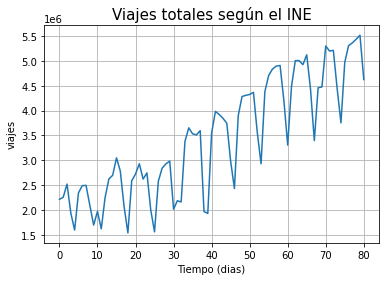

In [33]:
plt.plot(df_ine.values)
plt.grid(True)
plt.title("Viajes totales según el INE", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

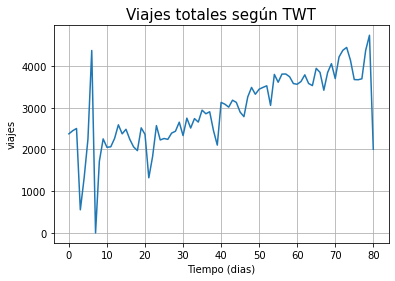

In [34]:
plt.plot(df_twt.values)
plt.grid(True)
plt.title("Viajes totales según TWT", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

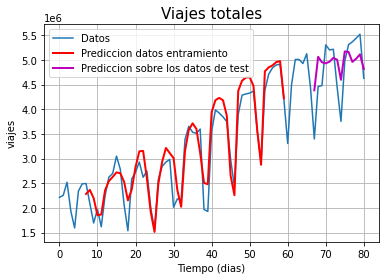

In [35]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset_ine)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset_ine)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset_ine), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_ine))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.show()

In [36]:
results=testPredict
print(len(results))

14


In [37]:
test = testY_scalerInverse[0]

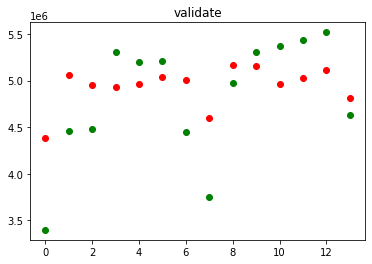

In [38]:
plt.scatter(range(len(test)),test,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

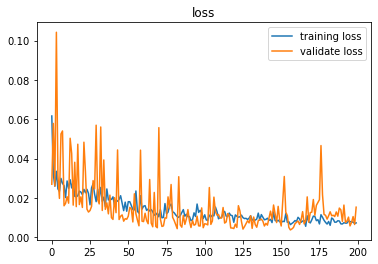

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [40]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

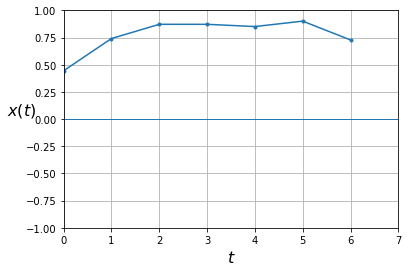

In [41]:
n_steps = 6
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [42]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,4383470.5
2020-06-08,5062377.5
2020-06-09,4951076.5
2020-06-10,4929985.0
2020-06-11,4962698.0
2020-06-12,5041709.0
2020-06-13,5003315.0
2020-06-14,4595049.5
2020-06-15,5170742.0
2020-06-16,5160620.0


In [43]:
datosReales = df_ine['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,3396402,4383470.5
2020-06-08,4461143,5062377.5
2020-06-09,4478072,4951076.5
2020-06-10,5303428,4929985.0
2020-06-11,5200931,4962698.0
2020-06-12,5215302,5041709.0
2020-06-13,4445190,5003315.0
2020-06-14,3753016,4595049.5
2020-06-15,4973188,5170742.0
2020-06-16,5308885,5160620.0


In [44]:
compara.to_excel('Resultados INE - TWT.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [45]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias_twt = df_twt['2020-5-18':'2020-5-24']
Dias_ine = df_ine['2020-5-18':'2020-5-24']

In [46]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset1, dataset2, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset2)-look_back-dias):
    a = []
    for x in range(look_back):
        a.append(dataset2[i+x])  
        a.append(dataset1[i+x])
    a = np.array(a)
    a = np.reshape(a, (7, 1, 2))
    dataX.append(a)
    dataY.append(dataset2[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [47]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train_twt, train_ine, look_back, 1)
testX1, testY1 = create_dataset2(test_twt, test_ine, look_back, 1)

trainX2, trainY2 = create_dataset2(train_twt, train_ine, look_back, 2)
testX2, testY2 = create_dataset2(test_twt, test_ine, look_back, 2)

trainX3, trainY3 = create_dataset2(train_twt, train_ine, look_back, 3)
testX3, testY3 = create_dataset2(test_twt, test_ine, look_back, 3)

trainX4, trainY4 = create_dataset2(train_twt, train_ine, look_back, 4)
testX4, testY4 = create_dataset2(test_twt, test_ine, look_back, 4)

trainX5, trainY5 = create_dataset2(train_twt, train_ine, look_back, 5)
testX5, testY5 = create_dataset2(test_twt, test_ine, look_back, 5)

trainX6, trainY6 = create_dataset2(train_twt, train_ine, look_back, 6)
testX6, testY6 = create_dataset2(test_twt, test_ine, look_back, 6)

In [48]:
print(trainX1)

[[[[0.16999608 0.50126636]]

  [[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]]


 [[[0.18028718 0.5170958 ]]

  [[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]]


 [[[0.2470504  0.528282  ]]

  [[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]]


 [[[0.10007131 0.11692698]]

  [[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]]


 [[[0.01443306 0.27838752]]

  [[0.20226192 0.47425076]]

  [[0.23910356 0.9229633 ]]

  [[0.24053836 0.        ]]

  [[0.1389401  0.3623892 ]]

  [[0.03971621 0.4755171 ]]

  [[0.

In [49]:
print(trainY1)

[0.1389401  0.03971621 0.10891479 0.02047423 0.17865783 0.27293295
 0.2914425  0.37988257 0.313093   0.13297123 0.         0.26343662
 0.29775453 0.34997272 0.27233207 0.30363703 0.11689752 0.00537395
 0.26156402 0.32788748 0.3494845  0.36331165 0.11988008 0.16276813
 0.1565342  0.46347785 0.5314964  0.50147784 0.49586993 0.51747626
 0.10823756 0.09844148 0.5044481  0.61485875 0.59899086 0.5796803
 0.5546241  0.3633111  0.22455525 0.59261984 0.689921   0.6962447
 0.7003162  0.71110225 0.50901634 0.34968656 0.7144731  0.7966052
 0.82881963 0.8441757  0.8469062  0.6693162 ]


In [50]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 2))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 2))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 2))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 2))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 2))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 2))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 2))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 2))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 2))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 2))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 2))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 2))

In [51]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1840      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,541
Trainable params: 76,541
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0105 - val_loss: 0.0154
Epoch 123/200
52/52 - 0s - loss: 0.0128 - val_loss: 0.0250
Epoch 124/200
52/52 - 0s - loss: 0.0113 - val_loss: 0.0117
Epoch 125/200
52/52 - 0s - loss: 0.0110 - val_loss: 0.0141
Epoch 126/200
52/52 - 0s - loss: 0.0096 - val_loss: 0.0098
Epoch 127/200
52/52 - 0s - loss: 0.0095 - val_loss: 0.0105
Epoch 128/200
52/52 - 0s - loss: 0.0109 - val_loss: 0.0105
Epoch 129/200
52/52 - 0s - loss: 0.0102 - val_loss: 0.0107
Epoch 130/200
52/52 - 0s - loss: 0.0096 - val_loss: 0.0083
Epoch 131/200
52/52 - 0s - loss: 0.0100 - val_loss: 0.0081
Epoch 132/200
52/52 - 0s - loss: 0.0092 - val_loss: 0.0086
Epoch 133/200
52/52 - 0s - loss: 0.0141 - val_loss: 0.0134
Epoch 134/200
52/52 - 0s - loss: 0.0114 - val_loss: 0.0096
Epoch 135/200
52/52 - 0s - loss: 0.0100 - val_loss: 0.0103
Epoch 136/200
52/52 - 0s - loss: 0.0082 - val_loss: 0.0090
Epoch 137/200
52/52 - 0s - loss: 0.0098 - val_loss: 0.0087
Epoch 138/200
52/52 - 0s - loss: 0.0107 - val_loss: 0.0090
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0158 - val_loss: 0.0075
Epoch 44/200
51/51 - 0s - loss: 0.0179 - val_loss: 0.0100
Epoch 45/200
51/51 - 0s - loss: 0.0168 - val_loss: 0.0209
Epoch 46/200
51/51 - 0s - loss: 0.0121 - val_loss: 0.0086
Epoch 47/200
51/51 - 0s - loss: 0.0144 - val_loss: 0.0101
Epoch 48/200
51/51 - 0s - loss: 0.0120 - val_loss: 0.0129
Epoch 49/200
51/51 - 0s - loss: 0.0141 - val_loss: 0.0121
Epoch 50/200
51/51 - 0s - loss: 0.0174 - val_loss: 0.0110
Epoch 51/200
51/51 - 0s - loss: 0.0132 - val_loss: 0.0104
Epoch 52/200
51/51 - 0s - loss: 0.0144 - val_loss: 0.0143
Epoch 53/200
51/51 - 0s - loss: 0.0139 - val_loss: 0.0080
Epoch 54/200
51/51 - 0s - loss: 0.0114 - val_loss: 0.0124
Epoch 55/200
51/51 - 0s - loss: 0.0116 - val_loss: 0.0110
Epoch 56/200
51/51 - 0s - loss: 0.0138 - val_loss: 0.0081
Epoch 57/200
51/51 - 0s - loss: 0.0129 - val_loss: 0.0103
Epoch 58/200
51/51 - 0s - loss: 0.0092 - val_loss: 0.0138
Epoch 59/200
51/51 - 0s - loss: 0.0129 - val_loss: 0.0077
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0091 - val_loss: 0.0113
Epoch 184/200
51/51 - 0s - loss: 0.0080 - val_loss: 0.0103
Epoch 185/200
51/51 - 0s - loss: 0.0107 - val_loss: 0.0121
Epoch 186/200
51/51 - 0s - loss: 0.0101 - val_loss: 0.0104
Epoch 187/200
51/51 - 0s - loss: 0.0070 - val_loss: 0.0120
Epoch 188/200
51/51 - 0s - loss: 0.0092 - val_loss: 0.0136
Epoch 189/200
51/51 - 0s - loss: 0.0090 - val_loss: 0.0129
Epoch 190/200
51/51 - 0s - loss: 0.0091 - val_loss: 0.0249
Epoch 191/200
51/51 - 0s - loss: 0.0111 - val_loss: 0.0142
Epoch 192/200
51/51 - 0s - loss: 0.0086 - val_loss: 0.0234
Epoch 193/200
51/51 - 0s - loss: 0.0075 - val_loss: 0.0158
Epoch 194/200
51/51 - 0s - loss: 0.0093 - val_loss: 0.0126
Epoch 195/200
51/51 - 0s - loss: 0.0080 - val_loss: 0.0135
Epoch 196/200
51/51 - 0s - loss: 0.0089 - val_loss: 0.0132
Epoch 197/200
51/51 - 0s - loss: 0.0087 - val_loss: 0.0100
Epoch 198/200
51/51 - 0s - loss: 0.0097 - val_loss: 0.0135
Epoch 199/200
51/51 - 0s - loss: 0.0081 - val_loss: 0.01

50/50 - 0s - loss: 0.0117 - val_loss: 0.0078
Epoch 105/200
50/50 - 0s - loss: 0.0106 - val_loss: 0.0116
Epoch 106/200
50/50 - 0s - loss: 0.0102 - val_loss: 0.0117
Epoch 107/200
50/50 - 0s - loss: 0.0102 - val_loss: 0.0094
Epoch 108/200
50/50 - 0s - loss: 0.0104 - val_loss: 0.0095
Epoch 109/200
50/50 - 0s - loss: 0.0101 - val_loss: 0.0084
Epoch 110/200
50/50 - 0s - loss: 0.0095 - val_loss: 0.0154
Epoch 111/200
50/50 - 0s - loss: 0.0110 - val_loss: 0.0176
Epoch 112/200
50/50 - 0s - loss: 0.0106 - val_loss: 0.0107
Epoch 113/200
50/50 - 0s - loss: 0.0111 - val_loss: 0.0108
Epoch 114/200
50/50 - 0s - loss: 0.0103 - val_loss: 0.0130
Epoch 115/200
50/50 - 0s - loss: 0.0105 - val_loss: 0.0232
Epoch 116/200
50/50 - 0s - loss: 0.0100 - val_loss: 0.0132
Epoch 117/200
50/50 - 0s - loss: 0.0085 - val_loss: 0.0217
Epoch 118/200
50/50 - 0s - loss: 0.0104 - val_loss: 0.0105
Epoch 119/200
50/50 - 0s - loss: 0.0093 - val_loss: 0.0125
Epoch 120/200
50/50 - 0s - loss: 0.0123 - val_loss: 0.0136
Epoch 121/2

49/49 - 0s - loss: 0.0189 - val_loss: 0.0128
Epoch 25/200
49/49 - 0s - loss: 0.0194 - val_loss: 0.0088
Epoch 26/200
49/49 - 0s - loss: 0.0209 - val_loss: 0.0096
Epoch 27/200
49/49 - 0s - loss: 0.0145 - val_loss: 0.0105
Epoch 28/200
49/49 - 0s - loss: 0.0202 - val_loss: 0.0175
Epoch 29/200
49/49 - 0s - loss: 0.0169 - val_loss: 0.0183
Epoch 30/200
49/49 - 0s - loss: 0.0156 - val_loss: 0.0161
Epoch 31/200
49/49 - 0s - loss: 0.0173 - val_loss: 0.0231
Epoch 32/200
49/49 - 0s - loss: 0.0183 - val_loss: 0.0149
Epoch 33/200
49/49 - 0s - loss: 0.0148 - val_loss: 0.0467
Epoch 34/200
49/49 - 0s - loss: 0.0184 - val_loss: 0.0123
Epoch 35/200
49/49 - 0s - loss: 0.0152 - val_loss: 0.0095
Epoch 36/200
49/49 - 0s - loss: 0.0130 - val_loss: 0.0351
Epoch 37/200
49/49 - 0s - loss: 0.0184 - val_loss: 0.0215
Epoch 38/200
49/49 - 0s - loss: 0.0173 - val_loss: 0.0445
Epoch 39/200
49/49 - 0s - loss: 0.0155 - val_loss: 0.0858
Epoch 40/200
49/49 - 0s - loss: 0.0167 - val_loss: 0.0364
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0111 - val_loss: 0.0111
Epoch 166/200
49/49 - 0s - loss: 0.0095 - val_loss: 0.0108
Epoch 167/200
49/49 - 0s - loss: 0.0126 - val_loss: 0.0117
Epoch 168/200
49/49 - 0s - loss: 0.0099 - val_loss: 0.0121
Epoch 169/200
49/49 - 0s - loss: 0.0107 - val_loss: 0.0111
Epoch 170/200
49/49 - 0s - loss: 0.0093 - val_loss: 0.0062
Epoch 171/200
49/49 - 0s - loss: 0.0087 - val_loss: 0.0063
Epoch 172/200
49/49 - 0s - loss: 0.0082 - val_loss: 0.0116
Epoch 173/200
49/49 - 0s - loss: 0.0112 - val_loss: 0.0192
Epoch 174/200
49/49 - 0s - loss: 0.0125 - val_loss: 0.0163
Epoch 175/200
49/49 - 0s - loss: 0.0113 - val_loss: 0.0113
Epoch 176/200
49/49 - 0s - loss: 0.0116 - val_loss: 0.0088
Epoch 177/200
49/49 - 0s - loss: 0.0102 - val_loss: 0.0241
Epoch 178/200
49/49 - 0s - loss: 0.0106 - val_loss: 0.0057
Epoch 179/200
49/49 - 0s - loss: 0.0103 - val_loss: 0.0078
Epoch 180/200
49/49 - 0s - loss: 0.0121 - val_loss: 0.0074
Epoch 181/200
49/49 - 0s - loss: 0.0105 - val_loss: 0.03

Epoch 86/200
48/48 - 0s - loss: 0.0121 - val_loss: 0.0126
Epoch 87/200
48/48 - 0s - loss: 0.0114 - val_loss: 0.0365
Epoch 88/200
48/48 - 0s - loss: 0.0118 - val_loss: 0.0127
Epoch 89/200
48/48 - 0s - loss: 0.0115 - val_loss: 0.0189
Epoch 90/200
48/48 - 0s - loss: 0.0112 - val_loss: 0.0114
Epoch 91/200
48/48 - 0s - loss: 0.0119 - val_loss: 0.0222
Epoch 92/200
48/48 - 0s - loss: 0.0115 - val_loss: 0.0121
Epoch 93/200
48/48 - 0s - loss: 0.0134 - val_loss: 0.0077
Epoch 94/200
48/48 - 0s - loss: 0.0121 - val_loss: 0.0435
Epoch 95/200
48/48 - 0s - loss: 0.0117 - val_loss: 0.0063
Epoch 96/200
48/48 - 0s - loss: 0.0123 - val_loss: 0.0276
Epoch 97/200
48/48 - 0s - loss: 0.0113 - val_loss: 0.0141
Epoch 98/200
48/48 - 0s - loss: 0.0129 - val_loss: 0.0476
Epoch 99/200
48/48 - 0s - loss: 0.0098 - val_loss: 0.0329
Epoch 100/200
48/48 - 0s - loss: 0.0108 - val_loss: 0.0088
Epoch 101/200
48/48 - 0s - loss: 0.0111 - val_loss: 0.0191
Epoch 102/200
48/48 - 0s - loss: 0.0099 - val_loss: 0.0204
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0466 - val_loss: 0.0256
Epoch 7/200
47/47 - 0s - loss: 0.0394 - val_loss: 0.0309
Epoch 8/200
47/47 - 0s - loss: 0.0379 - val_loss: 0.0920
Epoch 9/200
47/47 - 0s - loss: 0.0380 - val_loss: 0.0385
Epoch 10/200
47/47 - 0s - loss: 0.0355 - val_loss: 0.1784
Epoch 11/200
47/47 - 0s - loss: 0.0384 - val_loss: 0.0507
Epoch 12/200
47/47 - 0s - loss: 0.0358 - val_loss: 0.0457
Epoch 13/200
47/47 - 0s - loss: 0.0393 - val_loss: 0.0261
Epoch 14/200
47/47 - 0s - loss: 0.0393 - val_loss: 0.0486
Epoch 15/200
47/47 - 0s - loss: 0.0350 - val_loss: 0.0252
Epoch 16/200
47/47 - 0s - loss: 0.0391 - val_loss: 0.0297
Epoch 17/200
47/47 - 0s - loss: 0.0400 - val_loss: 0.1205
Epoch 18/200
47/47 - 0s - loss: 0.0360 - val_loss: 0.0296
Epoch 19/200
47/47 - 0s - loss: 0.0341 - val_loss: 0.0937
Epoch 20/200
47/47 - 0s - loss: 0.0375 - val_loss: 0.0276
Epoch 21/200
47/47 - 0s - loss: 0.0345 - val_loss: 0.0273
Epoch 22/200
47/47 - 0s - loss: 0.0327 - val_loss: 0.0532
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0082 - val_loss: 0.0134
Epoch 148/200
47/47 - 0s - loss: 0.0087 - val_loss: 0.0052
Epoch 149/200
47/47 - 0s - loss: 0.0074 - val_loss: 0.0048
Epoch 150/200
47/47 - 0s - loss: 0.0073 - val_loss: 0.0025
Epoch 151/200
47/47 - 0s - loss: 0.0072 - val_loss: 0.0145
Epoch 152/200
47/47 - 0s - loss: 0.0073 - val_loss: 0.0091
Epoch 153/200
47/47 - 0s - loss: 0.0063 - val_loss: 0.0058
Epoch 154/200
47/47 - 0s - loss: 0.0080 - val_loss: 0.0071
Epoch 155/200
47/47 - 0s - loss: 0.0068 - val_loss: 0.0069
Epoch 156/200
47/47 - 0s - loss: 0.0078 - val_loss: 0.0086
Epoch 157/200
47/47 - 0s - loss: 0.0085 - val_loss: 0.0047
Epoch 158/200
47/47 - 0s - loss: 0.0092 - val_loss: 0.0184
Epoch 159/200
47/47 - 0s - loss: 0.0065 - val_loss: 0.0230
Epoch 160/200
47/47 - 0s - loss: 0.0093 - val_loss: 0.0138
Epoch 161/200
47/47 - 0s - loss: 0.0075 - val_loss: 0.0124
Epoch 162/200
47/47 - 0s - loss: 0.0068 - val_loss: 0.0285
Epoch 163/200
47/47 - 0s - loss: 0.0073 - val_loss: 0.01

# Preparamos los datos para el test

In [52]:
# cargamos el dataframe en la variable dataset
dataset_twt = Dias_twt.values
dataset_ine = Dias_ine.values

# convertimos los enteros en floats
dataset_twt = dataset_twt.astype('float32')
dataset_ine = dataset_ine.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_twt = scaler.fit_transform(dataset_twt)
dataset_ine = scaler.fit_transform(dataset_ine)

In [53]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset3(dataset1, dataset2):
  dataX = []
  for x in range(len(dataset2)):
    dataX.append(dataset2[x])  
    dataX.append(dataset1[x])
  dataX = np.array(dataX)
  dataX = np.reshape(dataX, (7, 1, 2))
  return np.array(dataX)

In [54]:
# usamos la funcion definida previamente para crear el dataset
testX = create_dataset3(dataset_twt, dataset_ine)

In [55]:
#remodelamos los datos
testX = np.reshape(testX, (1, 7, 2))

# Realizamos la prediccion 

In [56]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.8431873 ]
 [1.1106517 ]
 [0.949291  ]
 [0.9051898 ]
 [0.9813031 ]
 [0.74208987]
 [0.46941304]]


# Re-Convertimos los resultados

In [57]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[4143021],
       [4528122],
       [4295791],
       [4232293],
       [4341883],
       [3997458],
       [3604852]])

# Visualizamos el pronostico

<AxesSubplot:>

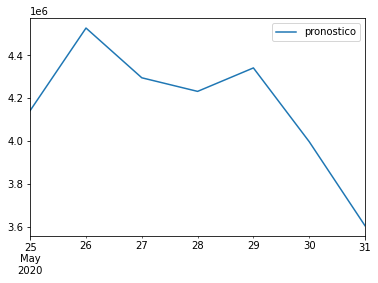

In [58]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [59]:
datosReales = df_ine['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,4382232,4143021
2020-05-26,4709433,4528122
2020-05-27,4837770,4295791
2020-05-28,4898946,4232293
2020-05-29,4909824,4341883
2020-05-30,4202334,3997458
2020-05-31,3305717,3604852


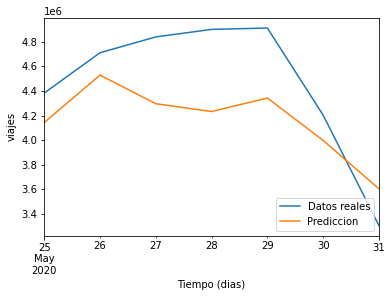

In [60]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [61]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 385872.29 MAE
Resultado del test: 183182277596.29 MSE
Resultado del test: 427997.99 RMSE
Resultado del test: 10.28 CVRMSE
Resultado del test: 9.24 MAPE


In [62]:
# calculamos las metricas de error para cada dia por separado
for i in range(7):
    testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion.values[i], datosReales.values[i])
    day = i + 1
    print('Resultado del test dia %d: %.2f MAE' % (day, testScore_MAE))
    print('Resultado del test dia %d: %.2f MSE' % (day, testScore_MSE))
    print('Resultado del test dia %d: %.2f RMSE' % (day, testScore_RMSE))
    print('Resultado del test dia %d: %.2f CVRMSE' % (day, testScore_CVRMSE))
    print('Resultado del test dia %d: %.2f MAPE \n' % (day, testScore_MAPE))

Resultado del test dia 1: 239211.00 MAE
Resultado del test dia 1: 57221902521.00 MSE
Resultado del test dia 1: 239211.00 RMSE
Resultado del test dia 1: 5.77 CVRMSE
Resultado del test dia 1: 5.77 MAPE 

Resultado del test dia 2: 181311.00 MAE
Resultado del test dia 2: 32873678721.00 MSE
Resultado del test dia 2: 181311.00 RMSE
Resultado del test dia 2: 4.00 CVRMSE
Resultado del test dia 2: 4.00 MAPE 

Resultado del test dia 3: 541979.00 MAE
Resultado del test dia 3: 293741236441.00 MSE
Resultado del test dia 3: 541979.00 RMSE
Resultado del test dia 3: 12.62 CVRMSE
Resultado del test dia 3: 12.62 MAPE 

Resultado del test dia 4: 666653.00 MAE
Resultado del test dia 4: 444426222409.00 MSE
Resultado del test dia 4: 666653.00 RMSE
Resultado del test dia 4: 15.75 CVRMSE
Resultado del test dia 4: 15.75 MAPE 

Resultado del test dia 5: 567941.00 MAE
Resultado del test dia 5: 322556979481.00 MSE
Resultado del test dia 5: 567941.00 RMSE
Resultado del test dia 5: 13.08 CVRMSE
Resultado del test d